In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.distributions
from PIL import Image
from texture_vae.models.texture_vae import Autoencoder
import texture_vae.utils.texture_dataset as dataset
from torchsummary import summary
import os
import torchvision
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm


# Constants

In [2]:
TEXTURE_SIZE = 128
BATCH_SIZE = 32
LATENT_DIMS = 128
DEVICE="cuda"

# Texture VAE Details

Excellent reading on VAEs 
https://towardsdatascience.com/generating-images-with-autoencoders-77fd3a8dd368

## Model Loading

Load the model, its weights and setup Dataloader

In [3]:
def load_model(snapshot_fn:str, latent_dims: int, texture_size:int):
    autoencoder = Autoencoder(latent_dims=latent_dims, image_size=texture_size, device=DEVICE)
    autoencoder.load_state_dict(torch.load(snapshot_fn))
    return autoencoder

## Plot Samples from normal distribution

In [4]:
def show_samples(sampled_images, dpi=150):
    plt.rcParams["savefig.bbox"] = 'tight'
    plt.rcParams['figure.dpi'] = dpi
    plt.axis('off')
    from torchvision.utils import make_grid
    import torchvision.transforms.functional as F
    grid = make_grid(sampled_images)
    grid = F.to_pil_image(grid)
    plt.imshow(grid)
    plt.show()

In [5]:

def sample_around(latent, num_samples: int):
    with torch.inference_mode():
        seed_image = ae.sample(latent)
        x_rec, mu, logvar,_ = ae(seed_image)
        z = latent + torch.normal(mu.repeat(num_samples,1), torch.exp(logvar).repeat(num_samples,1))
        print(z)
        return ae.sample(z + 0.5*torch.randn(4,16))

    
    
    

In [15]:
ae = load_model("../snapshots/snapshot_lat128_res128_kl0.6.pth", texture_size=TEXTURE_SIZE, latent_dims=LATENT_DIMS)
train_data= torch.utils.data.DataLoader(dataset.TextureDataset('../bricks1000',
                                            transform=torchvision.transforms.Resize(TEXTURE_SIZE)),
                                           batch_size=BATCH_SIZE,
                                       shuffle=True)

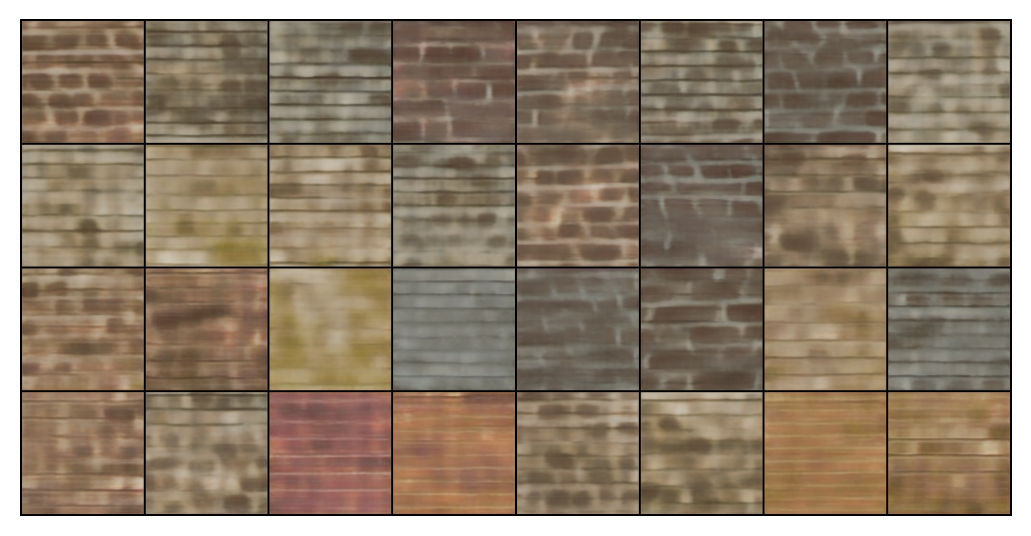

In [16]:
sample_seed = torch.normal(0, 1, (32,LATENT_DIMS)).to(ae.device)
sampled_images = ae.sample(sample_seed)
show_samples(sampled_images, 200)



## Visualize high dimensional data in 2D using T-SNE

See https://pypi.org/project/tsne-torch/

Excerpt from  "Maaten, L : Accelerating t-SNE using Tree-Based Algorithms"

*In a low-dimensional embedding, each (high-dimensional) object is represented by a low-dimensional point in such a way, that
nearby points correspond to similar objects and that distant points correspond to dissimilar
objects.*


In [17]:
def compute_all_latents(train_data: torch.utils.data.DataLoader, ae: Autoencoder):
    """run the training data through the autoencoder to get the corresponding latent features"""
    latents = []
    labels = []
    with torch.no_grad():
        with tqdm(train_data, unit="batch") as tq:
            for x, lbl in tq:
                x = x.to(ae.device)
                x_hat, mu, logvar, z = ae(x)
                latents.append(z)
                labels.append(lbl)
    # the last batch might be incomplete, so we just ignore it here
    latents.pop()
    labels.pop()
    all_latents = torch.stack(latents, dim=0).reshape(-1, LATENT_DIMS)
    all_labels  = torch.tensor(list(itertools.chain.from_iterable(labels)), dtype=torch.int32)         
    return all_latents, all_labels
        

In [18]:
def calculate_tsne(latents: torch.Tensor, n_iter:int):
    from tsne_torch import TorchTSNE as TSNE
    x_emb = TSNE(n_components=2, perplexity=30, n_iter=n_iter, verbose=True).fit_transform(latents)  # returns shape (n_samples, 2)
    return x_emb

In [19]:
all_latents, all_labels = compute_all_latents(train_data, ae)

100%|██████████| 282/282 [00:07<00:00, 36.78batch/s]


In [20]:
# use only a uniform sampled subset of the data
sub_indicies = torch.floor((torch.rand(1000,)*all_latents.shape[0])).type(torch.LongTensor)
shown_latents = all_latents[sub_indicies]
shown_labels = all_labels[sub_indicies]
embeds = calculate_tsne(shown_latents, n_iter=1000)

using cuda
initializing...
computing p-values...


  0%|          | 0/1000 [00:00<?, ?it/s]

fitting...


  0%|          | 0/1000 [00:00<?, ?it/s]

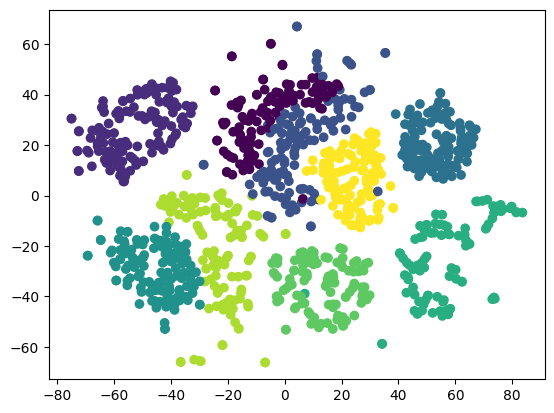

In [21]:
plt.rcParams['figure.dpi'] = 100
plt.scatter(embeds[:,0], embeds[:,1], c=shown_labels.detach().cpu().numpy())
plt.show()